### Embedded deep feature selection

In [4]:
import tensorflow as tf
import numpy as np
import random as rn
seed = 1
rand = np.random.RandomState(seed)
np.random.seed(1)
rn.seed(1)
# Setting the graph-level random seed.
tf.random.set_seed(1)
import os
os.environ['PYTHONHASHSEED']=str(1)
import keras
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Concatenate, Layer, Multiply, Reshape, ThresholdedReLU, Dot, \
Activation,LocallyConnected1D,Input, ActivityRegularization, Dropout,  Dense, Lambda
from tensorflow.keras import regularizers, losses
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import clone_model
import pandas as pd
from scipy.io import loadmat
from scipy.io.arff import loadarff 
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
import statistics
import pprint
from datetime import datetime


In [5]:
from generate import *
!cat /proc/cpuinfo
!cat /proc/meminfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [6]:
!pip install skrebate
from skrebate import ReliefF

  Created wheel for skrebate: filename=skrebate-0.62-cp37-none-any.whl size=29256 sha256=9a2f8ea9c58b5e291b28977270ae9b62b3fafa2c150f2888a3f1b74317471a5a
  Stored in directory: /root/.cache/pip/wheels/6b/0e/2f/540392932d3a01060f04c242d3b9bee80dfd87f63d80b3a9a0
Successfully built skrebate


### Classes

In [7]:
from tensorflow.keras.constraints import MinMaxNorm
class PairLayer(tf.keras.layers.Layer):

    def __init__(self, activation='sigmoid', cancelout_loss=True, lambda_1=0.002, lambda_2=0.001, lambda_3 = 0.0, init=None):
        super(PairLayer, self).__init__()
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.lambda_3 = lambda_3
        self.cancelout_loss = cancelout_loss
        
        if activation == 'sigmoid': self.activation = tf.sigmoid
        elif activation == 'softmax': self.activation = tf.nn.softmax
        else: self.activation = None
        if init == 'glorout' : self.init = tf.keras.initializers.GlorotNormal()
        else: self.init =  tf.keras.initializers.Constant(1)


    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1],),
            initializer=self.init,
            trainable=True,
            constraint=MinMaxNorm(min_value = 0, max_value = 1, rate = 1, axis = 0))
        
    def call(self, inputs):
        if self.cancelout_loss:
            shap = self.w.shape[0]
            self.add_loss( self.lambda_1 * tf.norm(self.w, ord=1)  + self.lambda_2 * tf.norm(self.w, ord=2))
            if self.lambda_3 != 0.0:
                self.add_loss(-self.lambda_3 * tf.math.reduce_variance(self.w*(1/shap)))

        if self.activation == None: return inputs * self.w
        else: return inputs * self.activation(self.w)
    
    def get_config(self):
        return {"activation": self.activation} 

In [8]:
class PairwiseFS(Model):
    def __init__(self, inputs, base_model, l1, l2=0.001, l3=0.0, activationCancel='sigmoid', initializer=None):
        self.l1 = l1
        self.inputDim = inputs.shape[1]
        dense = [] 
        inputLayer = Input(shape=(self.inputDim,))

        ##Construct pairwise
        cancel = PairLayer(activation=activationCancel, lambda_1=l1, lambda_2=l2, lambda_3=l3, init=initializer) (inputLayer)
        second = clone_model(base_model) 
        super().__init__(inputs=inputLayer, outputs=second (cancel))


    def get_support(self):
        weights = self.get_weights()[0]
        return weights

In [9]:
class NFSLayer(tf.keras.layers.Layer):
    def __init__(self, activation='sigmoid'):
        super(NFSLayer, self).__init__()
        
    def call(self, inputs):
        return inputs[1] * inputs[0]


In [10]:
class NeuralFS(Model):

    def __init__(self, inputs, base_model,l2, dense, l1=0.0, threshold=0.05):
        self.l2 = l2
        self.l1 = l1
        self.inputDim = inputs.shape[1]
        self.inputTensor = inputs
        self.denseHidden = dense
        self.threshold = threshold
        inputLayer = Input(shape=(self.inputDim,))
        dense1 = Dense(self.denseHidden, activation="relu", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1_l2(l1=self.l1, l2=self.l2))(inputLayer)
        dense2 = Dense(self.inputDim, activation=self.tr, kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1_l2(l1=self.l1, l2=self.l2))(dense1) #TL
        pairwise =NFSLayer()([inputLayer, dense2])
        second = clone_model(base_model) 
        ret = second (pairwise)
        super().__init__(inputs=inputLayer, outputs=second (pairwise))

    @tf.function
    def tr(self,x):
        theta = K.cast(self.threshold, K.floatx())
        a = K.cast(K.less(x,-theta) , K.floatx())
        b = K.cast(K.greater(x,theta), K.floatx())
        d = 1 -((1-a)*(1-b)) #A or B
        return x * d


    def get_support(self):
        inputLayer = Input(shape=(self.inputDim,))
        dense1 = Dense(self.denseHidden, activation="relu", \
            weights=[self.get_weights()[0], self.get_weights()[1]])(inputLayer)
        dense2 = Dense(self.inputDim, activation=self.tr, \
                    weights=[self.get_weights()[2], self.get_weights()[3]])(dense1) #TL
        support = Model(inputs=inputLayer, outputs=dense2)
        support.compile(optimizer='adam',
                    loss=losses.CategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])
        prediction = support.predict(self.inputTensor)
        supportList = np.mean(prediction, axis=0)
        return supportList

### Generate dataset

In [11]:
#dataset, y, df, yb = generateSyntheticDataset(5000); dfstr="synth" #0-4 relevant 5-9 irrelevant 10-13 redondunt
#dataset, y, df = generateCovidDataset(); dfstr="covid"
#dataset, y, df = generateCardioDataset(); dfstr="cardio"
#dataset, y, df = generateDivorceDataset(); dfstr="divorce"
#dataset, y, df = generateChildhoodTumor(); dfstr="childTum"
#dataset, y, df = generateGDataset("breast-data.csv","breast-labels.csv" ); dfstr="breast"
#dataset, y, df = generateGDataset("breast-data.csv","breast-labels.csv",breast_feature ); dfstr="breast"
#dataset, y, df = generateGDataset("gravier-data.csv","gravier-labels.csv" ); dfstr="gravier"
#dataset, y, df = generateGDataset("arcene-data.csv","arcene-labels.csv" ); dfstr="arcene"
#dataset, y, df = generateGDataset("lsvt-data.csv","lsvt-labels.csv" ); dfstr="lsvt"
#dataset, y, df = generateGDataset("sonar-data.csv","sonar-labels.csv" ); dfstr="sonar"
#dataset, y, df = generateGDataset("gastro-data.csv","gastro-labels.csv" ); dfstr="gastro"
#dataset, y, df = generateGDataset("alon-data.csv","alon-labels.csv" ); dfstr="alon"
dataset, y, df = generateGDataset("synth-data.csv","synth-labels.csv" ); dfstr="synth"

X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.33, shuffle=False, random_state=1)
#print(X_train)

0       0
1       1
2       0
3       0
4       0
       ..
4995    1
4996    0
4997    1
4998    1
4999    0
Name: x, Length: 5000, dtype: int64
             0         1         2  ...        11        12        13
0     0.974438  0.512138  0.715295  ...  0.519670  0.712883  0.869745
1     0.565240  0.010234  0.972033  ...  0.002810  0.963683  0.427714
2     0.538846  0.944732  0.969621  ...  0.938753  0.971375  0.255436
3     0.538871  0.971940  0.942768  ...  0.971441  0.948124  0.187866
4     0.288532  0.783674  0.153898  ...  0.794125  0.146585  0.725685
...        ...       ...       ...  ...       ...       ...       ...
4995  0.117533  0.565023  0.699624  ...  0.583519  0.706882  0.633915
4996  0.807687  0.867163  0.706474  ...  0.878035  0.702215  0.336603
4997  0.020929  0.128088  0.979723  ...  0.132311  0.962284  0.480559
4998  0.694481  0.262472  0.531470  ...  0.250886  0.531593  0.069454
4999  0.846758  0.884634  0.713214  ...  0.887993  0.714862  0.602781

[5000 rows x 

### Utils

In [12]:
def activation_potential_analysis(X, weights):
    weights_first = weights[0]
    bias = weights[1]
    support = []
    p_ij = np.zeros((X.shape[1], len(weights_first[0])))
    for dim in range(len(weights_first)):
        for hidden in range(len(weights_first[0])):
            for trains in range(X.shape[0]):
                p_ij[dim][hidden] += abs(weights_first[dim][hidden]*X[trains][dim])
            p_ij[dim][hidden] = p_ij[dim][hidden]/X.shape[0] 
            
    sum_j = np.sum(p_ij, axis=1)
    return sum_j

In [13]:
def crossValScore(modelKey,k,X_train,y_train, mapModel, param, epc, bs, verb):
    n_splits = k
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    loss = []
    acc = []
    val_loss = []
    val_acc = []
    final_acc = []
    for train_index, val_index in kf.split(X_train):
        X_train_scal = MinMaxScaler().fit_transform(X_train)
        model = mapModel[modelKey](X_train_scal[train_index],y_train[train_index],param)
        model.compile(optimizer='adam',
                      loss=losses.CategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
        hist = model.fit(X_train_scal[train_index], y_train[train_index],
                         epochs=epc,
                         batch_size=bs,
                         validation_data = (X_train_scal[val_index], y_train[val_index]),
                         verbose=verb)

        loss.append(hist.history['loss'])
        acc.append(hist.history['accuracy'])
        val_loss.append([hist.history['val_loss']])
        val_acc.append(hist.history['val_accuracy'])
        final_acc.append(hist.history['accuracy'][-1])
        score = np.mean(final_acc)
    return score, acc, loss, final_acc
#print(val_acc)

In [14]:
def filterImportance(X_train,y_train):
    yb = y_train[:,1]
    fsMut = SelectKBest(score_func=mutual_info_classif, k='all')
    fsMut.fit(X_train, yb)
    fsR = ReliefF(n_neighbors=1, n_features_to_select=X_train.shape[1])
    X_train = fsR.fit_transform(X_train, yb)
    fsMSc = fsMut.scores_*(1/(np.amax(fsMut.scores_)))
    fsRSc = fsR.feature_importances_*(1/(np.amax(fsR.feature_importances_)))
    fsUnion = fsMSc + fsRSc
    return fsUnion

In [15]:
def showFeatures(key,w):
    print(w)
    if X_train.shape[1]<200:
        fig = plt.figure(figsize=(8, 8))
        fig.suptitle(key, fontsize=16)
        ax = fig.add_axes([0,0,1,1])
        if X_train.shape[1]>200:
            print("too much dimension to display")
        elif X_train.shape[1]>20:
            ax.barh(df.columns,[abs(i) for i in w])
        else:
            ax.bar(df.columns,[abs(i) for i in w])
        plt.show()

In [16]:
def computeSupport(w, n):
    sortedFeat = sorted(w)
    thres = sortedFeat[-n]
    support = []
    print(w)
    for i in w:
        if i < thres or i <= 0.0:
            support.append(False)
        else:
            support.append(True)
    pres = support.count(True)
    if pres < n:
        count = 0
        ind = 0
        while count < n-pres:
            if support[ind] == False:
                count += 1
                support[ind] = True
            ind += 1
    return support



In [17]:
def computeSupportPercent(w, p):
    sortedFeat = sorted(w)
    sortedFeat.reverse()
    sumFeat = np.sum(w)
    thresPerc = sumFeat*(p/100)
    support = []
    thres = 0
    for i in range(len(sortedFeat)):
        thres += sortedFeat[i]
        if thres+(1*(10**(-5))) >= round(thresPerc,7):
            return computeSupport(w,i+1)
    return False

In [18]:
def writeOut(name, params, result, dfstr):
    with open(name, "a") as file:
        file.write("###")
        file.write("\n")
        file.write(dfstr)
        file.write("\n")
        now = datetime.now()
        timestamp = datetime.timestamp(now)
        file.write(str(now))
        file.write("\n")
        file.write(str(params))
        file.write("\n")
        file.write(str(result))
        file.write("\n")


### Models

Choose a suitable baseline architecture manually

In [19]:
def createBaseline(X_train,y_train,params):
    baseline = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(params["dense1_baseline"],activation='relu', kernel_regularizer=regularizers.l1_l2(l1=params["l1_baseline"], l2=params["l2_baseline"]), kernel_initializer='glorot_normal'),
        Dense(params["dense2_baseline"],activation='relu', kernel_regularizer=regularizers.l1_l2(l1=params["l1_baseline"], l2=params["l2_baseline"]),  kernel_initializer='glorot_normal'),
        Dense(params["dense3_baseline"],activation='relu', kernel_regularizer=regularizers.l1_l2(l1=params["l1_baseline"], l2=params["l2_baseline"]),  kernel_initializer='glorot_normal'),
        Dense(y.shape[1], activation='softmax')
    ])
    return baseline




In [20]:
def createRegularized(X_train,y_train,params):
    regularized = Sequential([
    Dense(X_train.shape[1],activation='relu', kernel_regularizer=regularizers.l1(params["l1_regul"]), input_shape=(X_train.shape[1],)),
    clone_model(createBaseline(X_train,y_train,params))
    ])
    return regularized

In [21]:
def createDropout(X_train,y_train,params):
    dropout = Sequential([
    Dropout(.5),
    clone_model(createBaseline(X_train,y_train,params))
    ])
    return dropout

In [22]:
def createCancelOut(X_train,y_train,params):
    cancelOut =  PairwiseFS(inputs=X_train, base_model=createBaseline(X_train,y_train,params), l1=params["l1_cancelOut"], l2=params["l2_cancelOut"], l3=params["l3_cancelOut"], initializer=params["initialiser_cancelOut"])
    return cancelOut


In [23]:
def createPairwise(X_train,y_train,params):
    pairwise = PairwiseFS(inputs=X_train, base_model=createBaseline(X_train,y_train,params), l1=params["l1_pairwise"], l2=params["l2_pairwise"], l3=params["l3_pairwise"], activationCancel=None, initializer=params["initialiser_pairwise"])
    return pairwise

In [24]:
def createNeuralFS(X_train,y_train, params):
    neuralFS = NeuralFS(inputs=X_train, base_model=createBaseline(X_train,y_train,params), l2=params["l2_neuralfs"], dense=X_train.shape[1], l1=params["l1_neuralfs"],threshold=params["threshold_neuralfs"])
    return neuralFS


In [25]:
#Run this cell if you change any model
mapModel = {'neuralFS': createNeuralFS, "dropout": createDropout, "pairwise" : createPairwise,
           "cancelOut" : createCancelOut, "baseline": createBaseline, "regularized": createRegularized }

### Performance

In [26]:
def testModels(X_train, y_train, modelList,params,epc,percent=False,nFeat=None, showFeat=False, cols=False):
    retMap = {}
    baseline = createBaseline(X_train,y_train,params)
    baseline.compile(optimizer='adam',
    loss=losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    baseline.fit(X_train,y_train,epochs=epc, verbose=0)
    test_loss, test_acc = baseline.evaluate(X_test,  y_test, verbose=1)
    retMap["shape"] = X_train.shape
    retMap["test_acc_baseline"] = test_acc
    y_pred1 = baseline.predict(X_test)
    y_pred = np.argmax(y_pred1, axis=1)
    y_true = np.argmax(y_test, axis=1)
    bcr = balanced_accuracy_score(y_true, y_pred)
    retMap["test_bcr_baseline"] = bcr
    for key in modelList:
        print("$$__"+key)
        if key != "filter":
            #print(mapModel)
            model = mapModel[key](X_train,y_train,params)
            model.compile(optimizer='adam',
              loss=losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
            model.fit(X_train,y_train,epochs=epc, verbose=0)
            test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=1)
            y_pred1 = model.predict(X_test)
            y_pred = np.argmax(y_pred1, axis=1)
            y_true = np.argmax(y_test, axis=1)

            bcr = balanced_accuracy_score(y_true, y_pred)
            if key in ["baseline", "regularized", "dropout"]:
                w = activation_potential_analysis(X_train, model.get_weights())
                w = [abs(number) for number in w]
            else:
                w = model.get_support()
                w = [abs(number) for number in w]
            if showFeat:
                showFeatures(key,w)
            retMap["test_acc_full_"+key] = test_acc
            retMap["test_bcr_full_"+key] = bcr
            
        else:
            w = filterImportance(X_train, y_train)
            if showFeat:
                showFeatures(key,w)
        if nFeat != None:
            if percent == True:
                support = computeSupportPercent(w,nFeat)
            else:
                support = computeSupport(w,nFeat)
            print(support)
            print("\n")
            X_train_red = X_train[:,support]
            X_test_red = X_test[:,support]
            retMap["shape_reduced_"+key] = X_train_red.shape
            if cols == True:
                retMap["columns_reduced_"+key] = df.columns[support].values.tolist()
            baseline = createBaseline(X_train_red,y_train,params)
            baseline.compile(optimizer='adam',
                loss=losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
            baseline.fit(X_train_red,y_train,epochs=epc, verbose=0)
            test_loss, test_acc = baseline.evaluate(X_test_red,  y_test, verbose=0)
            retMap["test_acc_baseline_reduced_from_"+key] = test_acc
            y_pred1 = baseline.predict(X_test_red)
            y_pred = np.argmax(y_pred1, axis=1)
            y_true = np.argmax(y_test, axis=1)
            bcr = balanced_accuracy_score(y_true, y_pred)
            retMap["test_bcr_baseline_reduced_from_"+key] = bcr
    return retMap




Find best baseline architecture

In [27]:
if dfstr == 'arcene':
 params={'dense1_baseline': 10,
 'dense2_baseline': 10,
 'dense3_baseline': 10,
 'initialiser_cancelOut': 'glorout',
 'initialiser_pairwise': 'glorout',
 'k': 3,
 'l1_baseline': 0.001,
 'l1_cancelOut': 0.05,
 'l1_neuralfs': 0.0,
 'l1_pairwise': 0.05,
 'l1_regul': 0.01,
 'l2_baseline': 0.001,
 'l2_cancelOut': 0.0,
 'l2_neuralfs': 0.05,
 'l2_pairwise': 0.0,
 'l3_cancelOut': 0.3,
 'l3_pairwise': 0.0,
 'threshold_neuralfs': 0.005}


elif dfstr == 'synth':

  params = {'dense1_baseline': 100,
 'dense2_baseline': 10,
 'dense3_baseline': 100,
 'initialiser_cancelOut': 'glorout',
 'initialiser_pairwise': 'const',
 'k': 3,
 'l1_baseline': 0.001,
 'l1_cancelOut': 0.05,
 'l1_neuralfs': 0.0,
 'l1_pairwise': 0.05,
 'l1_regul': 0.01,
 'l2_baseline': 0.001,
 'l2_cancelOut': 0.05,
 'l2_neuralfs': 0.05,
 'l2_pairwise': 0.05,
 'l3_cancelOut': 0.3,
 'l3_pairwise': 0.0,
 'threshold_neuralfs': 0.05}

elif dfstr == 'gastro':
  params = {'dense1_baseline': 50,
 'dense2_baseline': 100,
 'dense3_baseline': 50,
 'initialiser_cancelOut': 'const',
 'initialiser_pairwise': 'glorout',
 'k': 3,
 'l1_baseline': 0.001,
 'l1_cancelOut': 0.05,
 'l1_neuralfs': 0.0,
 'l1_pairwise': 0.05,
 'l1_regul': 0.01,
 'l2_baseline': 0.01,
 'l2_cancelOut': 0.05,
 'l2_neuralfs': 0.05,
 'l2_pairwise': 0.0,
 'l3_cancelOut': 0.3,
 'l3_pairwise': 0.0,
 'threshold_neuralfs': 0.01}

elif dfstr == 'breast':
  params={'dense1_baseline': 10,
 'dense2_baseline': 50,
 'dense3_baseline': 10,
 'initialiser_cancelOut': 'const',
 'initialiser_pairwise': 'const',
 'k': 3,
 'l1_baseline': 0.001,
 'l1_cancelOut': 0.05,
 'l1_neuralfs': 0.0,
 'l1_pairwise': 0.05,
 'l1_regul': 0.01,
 'l2_baseline': 0.001,
 'l2_cancelOut': 0.0,
 'l2_neuralfs': 0.1,
 'l2_pairwise': 0.25,
 'l3_cancelOut': 1,
 'l3_pairwise': 0.005,
 'threshold_neuralfs': 0.05}
else:
  print("OK")
  params = {  "l1_baseline" : 0.001, "l2_baseline" : 0.001, "dense1_baseline" : 100, "dense2_baseline" : 100, "dense3_baseline" : 100,
              "l1_regul" : 0.03, "l1_cancelOut" : 0.6, "l2_cancelOut" : 0.2, "l3_cancelOut": 0, "initialiser_cancelOut" : 'const',
              "l1_pairwise" : 0.2, "l2_pairwise": 0.0, "l3_pairwise": 0.0, "initialiser_pairwise" : 'glorout', 
              "l1_neuralfs" : 0.00, "l2_neuralfs" : 0.05, "threshold_neuralfs" : 0.05
          }

In [28]:
pprint.pprint(params)

{'dense1_baseline': 100,
 'dense2_baseline': 10,
 'dense3_baseline': 100,
 'initialiser_cancelOut': 'glorout',
 'initialiser_pairwise': 'const',
 'k': 3,
 'l1_baseline': 0.001,
 'l1_cancelOut': 0.05,
 'l1_neuralfs': 0.0,
 'l1_pairwise': 0.05,
 'l1_regul': 0.01,
 'l2_baseline': 0.001,
 'l2_cancelOut': 0.05,
 'l2_neuralfs': 0.05,
 'l2_pairwise': 0.05,
 'l3_cancelOut': 0.3,
 'l3_pairwise': 0.0,
 'threshold_neuralfs': 0.05}


### Test 

In [29]:
pprint.pprint(params)
X_train = MinMaxScaler().fit_transform(X_train)
X_test = MinMaxScaler().fit_transform(X_test)

{'dense1_baseline': 100,
 'dense2_baseline': 10,
 'dense3_baseline': 100,
 'initialiser_cancelOut': 'glorout',
 'initialiser_pairwise': 'const',
 'k': 3,
 'l1_baseline': 0.001,
 'l1_cancelOut': 0.05,
 'l1_neuralfs': 0.0,
 'l1_pairwise': 0.05,
 'l1_regul': 0.01,
 'l2_baseline': 0.001,
 'l2_cancelOut': 0.05,
 'l2_neuralfs': 0.05,
 'l2_pairwise': 0.05,
 'l3_cancelOut': 0.3,
 'l3_pairwise': 0.0,
 'threshold_neuralfs': 0.05}


52/52 [==============================] - 0s 2ms/step - loss: 0.2457 - accuracy: 0.9309
$$__filter
[1.43181010e+00 1.42668167e+00 5.34613978e-01 1.97827584e+00
 8.78518824e-01 1.13520352e-01 3.85444810e-02 6.45414075e-02
 1.10087830e-01 4.33034813e-04 1.49985013e+00 1.43532992e+00
 6.89391902e-01 1.96564941e+00]


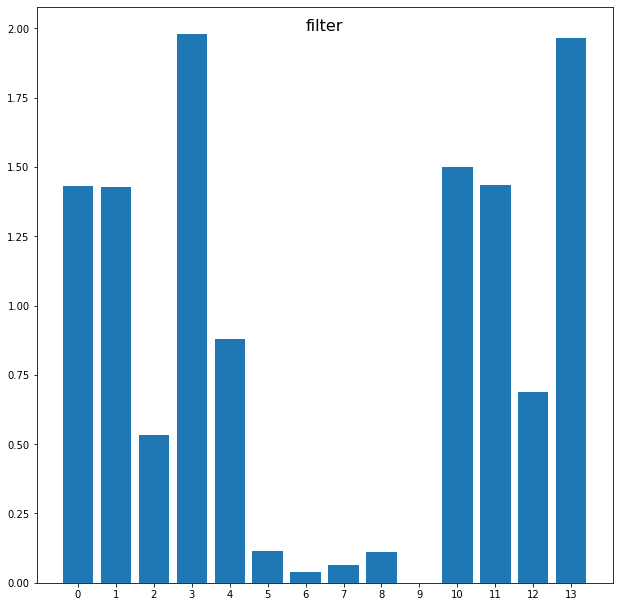

[1.43181010e+00 1.42668167e+00 5.34613978e-01 1.97827584e+00
 8.78518824e-01 1.13520352e-01 3.85444810e-02 6.45414075e-02
 1.10087830e-01 4.33034813e-04 1.49985013e+00 1.43532992e+00
 6.89391902e-01 1.96564941e+00]
[True, True, True, True, True, True, True, True, True, True, True, True, True, True]


$$__neuralFS
52/52 [==============================] - 0s 1ms/step - loss: 0.2670 - accuracy: 0.9236
[0.39877686, 0.4714006, 0.0, 0.2943351, 0.2761121, 0.0, 0.0, 0.0, 0.0, 0.0, 0.27601856, 0.40150225, 0.1167026, 0.16490202]


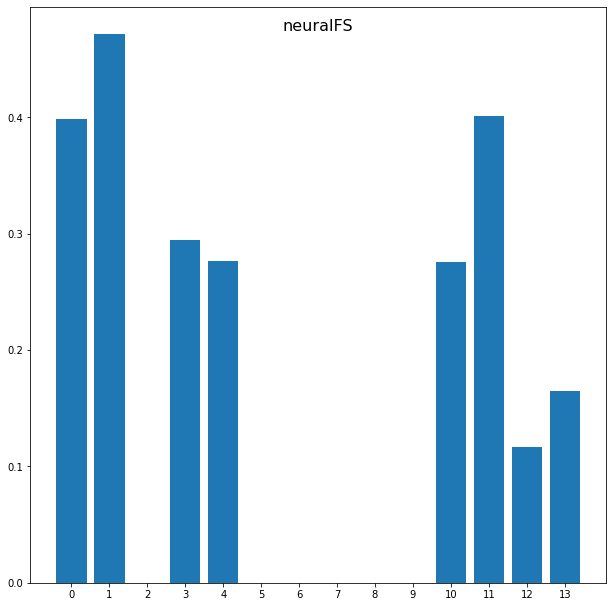

[0.39877686, 0.4714006, 0.0, 0.2943351, 0.2761121, 0.0, 0.0, 0.0, 0.0, 0.0, 0.27601856, 0.40150225, 0.1167026, 0.16490202]
[True, True, False, True, True, False, False, False, False, False, True, True, True, True]


$$__pairwise
52/52 [==============================] - 0s 1ms/step - loss: 0.3962 - accuracy: 0.8636
[0.14781593, 0.12864767, 8.154919e-05, 0.051058043, 0.07230414, 5.5070603e-05, 0.00038563553, 9.721172e-06, 0.00021265614, 1.8079714e-05, 5.959711e-05, 0.043764032, 6.6026754e-05, 0.097555965]


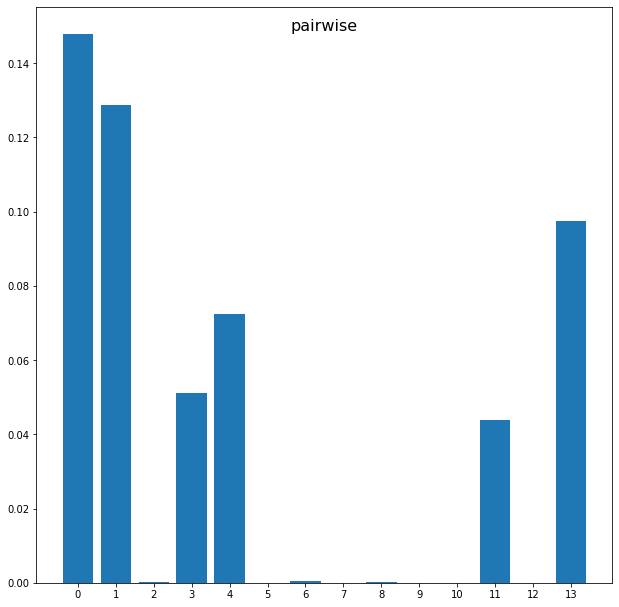

[0.14781593, 0.12864767, 8.154919e-05, 0.051058043, 0.07230414, 5.5070603e-05, 0.00038563553, 9.721172e-06, 0.00021265614, 1.8079714e-05, 5.959711e-05, 0.043764032, 6.6026754e-05, 0.097555965]
[True, True, True, True, True, True, True, False, True, True, True, True, True, True]


$$__cancelOut
52/52 [==============================] - 0s 2ms/step - loss: 0.2589 - accuracy: 0.9236
[0.0009802175, 0.0014465842, 0.00017181133, 0.0018365206, 0.0006260001, 7.844806e-06, 0.00020400436, 5.1046107e-05, 5.553268e-06, 4.1544292e-05, 0.00040061405, 0.0010488343, 7.1618146e-05, 0.0017624681]


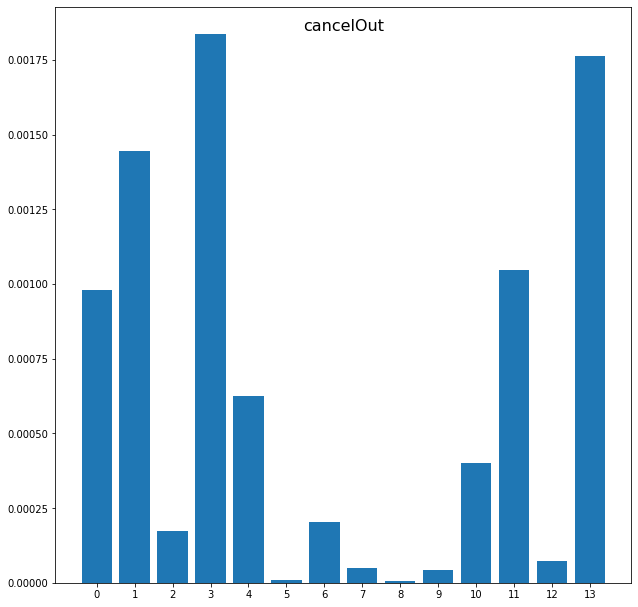

[0.0009802175, 0.0014465842, 0.00017181133, 0.0018365206, 0.0006260001, 7.844806e-06, 0.00020400436, 5.1046107e-05, 5.553268e-06, 4.1544292e-05, 0.00040061405, 0.0010488343, 7.1618146e-05, 0.0017624681]
[True, True, True, True, True, True, True, True, False, True, True, True, True, True]


$$__regularized
52/52 [==============================] - 0s 1ms/step - loss: 0.2838 - accuracy: 0.9212
[0.4297842840685283, 0.3078699691363079, 0.3271350526815208, 0.231227322374366, 0.1704166486350923, 0.014396140340062235, 0.01004898530930387, 0.012068974210806941, 0.01542168581456294, 0.021016653122517243, 0.10830609459409607, 0.20060070396484692, 0.17143091438267716, 0.13135977746560024]


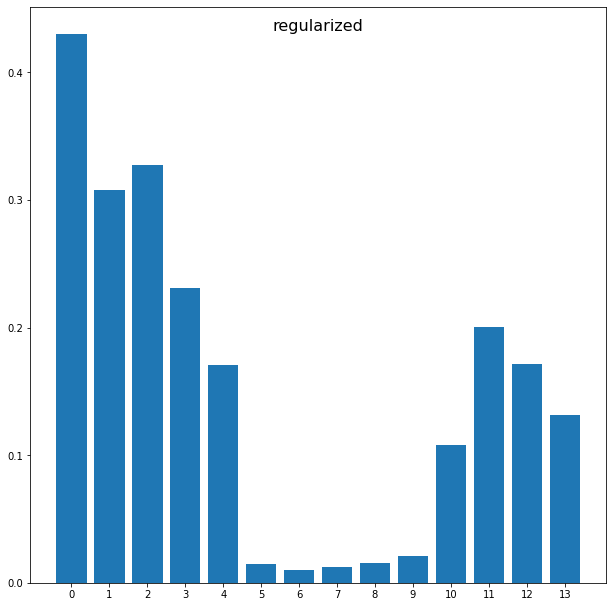

[0.4297842840685283, 0.3078699691363079, 0.3271350526815208, 0.231227322374366, 0.1704166486350923, 0.014396140340062235, 0.01004898530930387, 0.012068974210806941, 0.01542168581456294, 0.021016653122517243, 0.10830609459409607, 0.20060070396484692, 0.17143091438267716, 0.13135977746560024]
[True, True, True, True, True, True, True, True, True, True, True, True, True, True]


$$__baseline
52/52 [==============================] - 0s 1ms/step - loss: 0.2525 - accuracy: 0.9200
[1.7520582839198222, 1.948775834455167, 1.3359676420862248, 0.9979925104708574, 1.1034165254863741, 0.29616723253810945, 0.313807452484173, 0.2738256028270874, 0.26058244166813044, 0.28296116042370406, 1.6021697600596456, 1.6530263306896282, 1.1317145759704499, 1.0228451231728124]


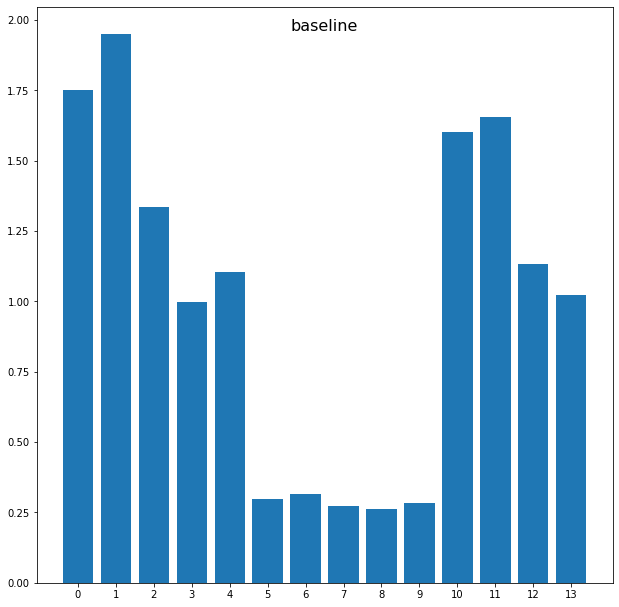

[1.7520582839198222, 1.948775834455167, 1.3359676420862248, 0.9979925104708574, 1.1034165254863741, 0.29616723253810945, 0.313807452484173, 0.2738256028270874, 0.26058244166813044, 0.28296116042370406, 1.6021697600596456, 1.6530263306896282, 1.1317145759704499, 1.0228451231728124]
[True, True, True, True, True, True, True, True, True, True, True, True, True, True]




In [30]:
modelList = ['filter','neuralFS','pairwise','cancelOut','regularized','baseline']

result = testModels(X_train, y_train, modelList, params, epc=100, percent=True, nFeat=100, showFeat=True, cols=False)


In [31]:
pprint.pprint(result)

{'shape': (3350, 14),
 'shape_reduced_baseline': (3350, 14),
 'shape_reduced_cancelOut': (3350, 13),
 'shape_reduced_filter': (3350, 14),
 'shape_reduced_neuralFS': (3350, 8),
 'shape_reduced_pairwise': (3350, 13),
 'shape_reduced_regularized': (3350, 14),
 'test_acc_baseline': 0.9309090971946716,
 'test_acc_baseline_reduced_from_baseline': 0.921818196773529,
 'test_acc_baseline_reduced_from_cancelOut': 0.9236363768577576,
 'test_acc_baseline_reduced_from_filter': 0.9260606169700623,
 'test_acc_baseline_reduced_from_neuralFS': 0.935757577419281,
 'test_acc_baseline_reduced_from_pairwise': 0.9296969771385193,
 'test_acc_baseline_reduced_from_regularized': 0.9309090971946716,
 'test_acc_full_baseline': 0.9200000166893005,
 'test_acc_full_cancelOut': 0.9236363768577576,
 'test_acc_full_neuralFS': 0.9236363768577576,
 'test_acc_full_pairwise': 0.8636363744735718,
 'test_acc_full_regularized': 0.9212121367454529,
 'test_bcr_baseline': 0.9309090909090909,
 'test_bcr_baseline_reduced_from_bas

Divide the number of feature by two

['filter', 'neuralFS', 'pairwise', 'cancelOut', 'regularized', 'baseline']
52/52 [==============================] - 0s 2ms/step - loss: 0.2453 - accuracy: 0.9261
$$__filter
[ 1.43181010e+00  1.42668167e+00  5.34613978e-01  1.97827584e+00
  8.78518824e-01  1.13520352e-01  3.85444810e-02  6.45414075e-02
  1.10087830e-01 -3.19871390e-04  1.49985013e+00  1.43532992e+00
  6.89391902e-01  1.96564941e+00]


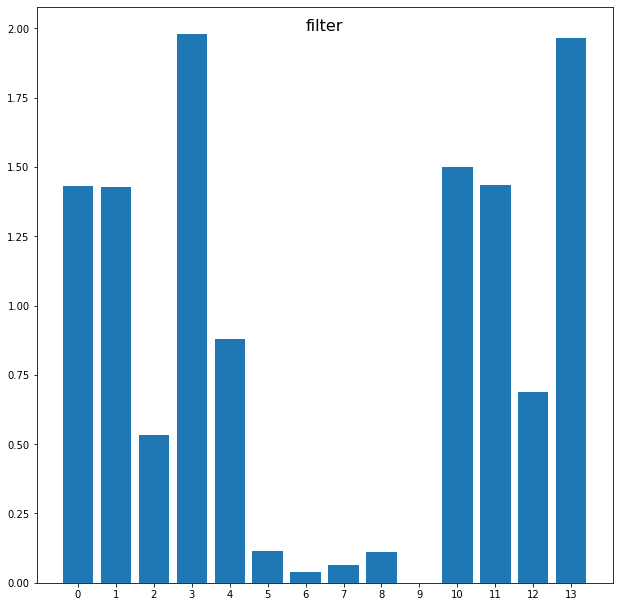

[ 1.43181010e+00  1.42668167e+00  5.34613978e-01  1.97827584e+00
  8.78518824e-01  1.13520352e-01  3.85444810e-02  6.45414075e-02
  1.10087830e-01 -3.19871390e-04  1.49985013e+00  1.43532992e+00
  6.89391902e-01  1.96564941e+00]
[True, True, False, True, True, False, False, False, False, False, True, True, False, True]


$$__neuralFS
52/52 [==============================] - 0s 2ms/step - loss: 0.3419 - accuracy: 0.8703
[0.29091278, 0.55803114, 0.0, 0.40735367, 0.3782408, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37169084, 0.0, 0.0, 0.3210763]


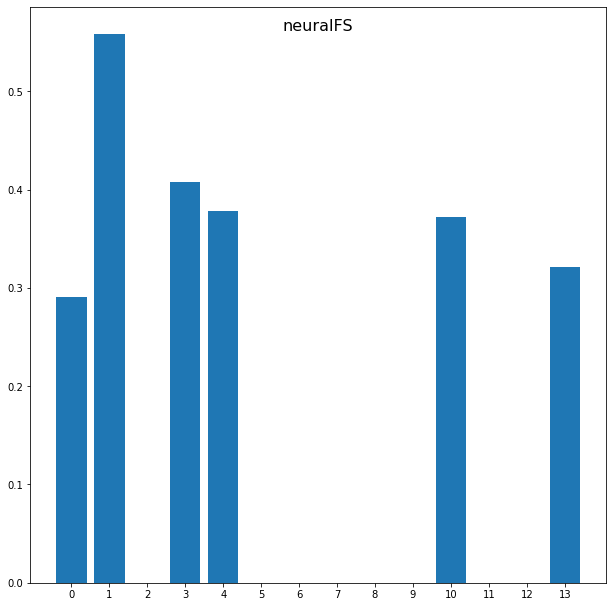

[0.29091278, 0.55803114, 0.0, 0.40735367, 0.3782408, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37169084, 0.0, 0.0, 0.3210763]
[True, True, True, True, True, False, False, False, False, False, True, False, False, True]


$$__pairwise
52/52 [==============================] - 0s 2ms/step - loss: 0.4015 - accuracy: 0.8667
[9.4306175e-05, 0.12885164, 0.00023014963, 0.1233245, 0.07628607, 4.7790872e-05, 2.2931372e-05, 3.157667e-06, 1.0634277e-05, 5.5359665e-06, 0.14760077, 0.04141162, 0.0001091887, 0.00024324899]


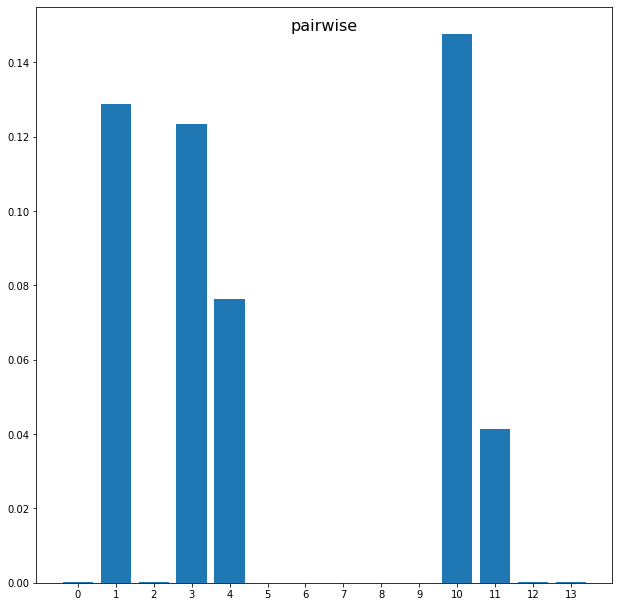

[9.4306175e-05, 0.12885164, 0.00023014963, 0.1233245, 0.07628607, 4.7790872e-05, 2.2931372e-05, 3.157667e-06, 1.0634277e-05, 5.5359665e-06, 0.14760077, 0.04141162, 0.0001091887, 0.00024324899]
[False, True, True, True, True, False, False, False, False, False, True, True, False, True]


$$__cancelOut
52/52 [==============================] - 0s 2ms/step - loss: 0.2484 - accuracy: 0.9279
[0.0007452492, 0.0011139563, 0.00022641657, 0.0014186165, 0.00075942645, 5.0174564e-05, 1.9725761e-05, 9.464455e-05, 0.00012421158, 0.00010764636, 6.232114e-05, 0.0006530193, 0.00034112303, 0.0015149742]


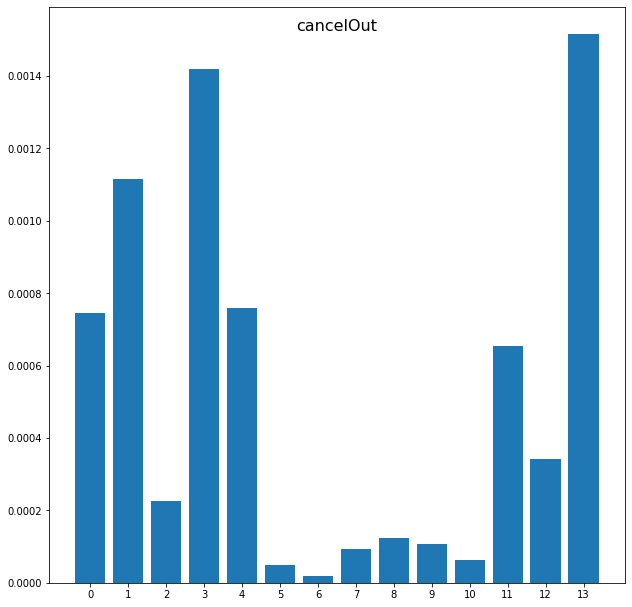

[0.0007452492, 0.0011139563, 0.00022641657, 0.0014186165, 0.00075942645, 5.0174564e-05, 1.9725761e-05, 9.464455e-05, 0.00012421158, 0.00010764636, 6.232114e-05, 0.0006530193, 0.00034112303, 0.0015149742]
[True, True, False, True, True, False, False, False, False, False, False, True, True, True]


$$__regularized
52/52 [==============================] - 0s 1ms/step - loss: 0.2792 - accuracy: 0.9279
[0.288926759894801, 0.49118420151520126, 0.20137385327816926, 0.2206878681247791, 0.16091969664858477, 0.007956299192926404, 0.033774411868422595, 0.013318749760960225, 0.011843240628043827, 0.011053996212575993, 0.4047468523573262, 0.18903723818894985, 0.3871020499250468, 0.12980036511310603]


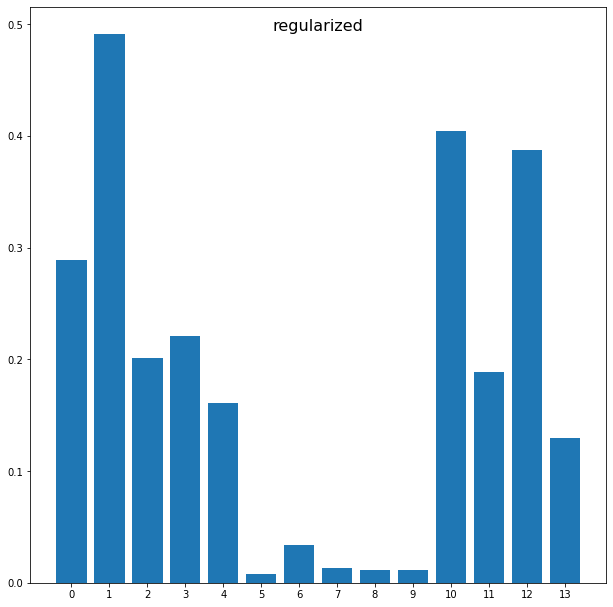

[0.288926759894801, 0.49118420151520126, 0.20137385327816926, 0.2206878681247791, 0.16091969664858477, 0.007956299192926404, 0.033774411868422595, 0.013318749760960225, 0.011843240628043827, 0.011053996212575993, 0.4047468523573262, 0.18903723818894985, 0.3871020499250468, 0.12980036511310603]
[True, True, True, True, False, False, False, False, False, False, True, True, True, False]


$$__baseline
52/52 [==============================] - 0s 2ms/step - loss: 0.2516 - accuracy: 0.9261
[1.7147461018558796, 1.665080601675228, 1.6093189849469705, 1.0876649842683437, 1.0819383536970213, 0.37572370141098166, 0.49478658475935844, 0.40651788309783454, 0.5056340970053906, 0.4934324213021037, 1.37300299139537, 1.524435679185529, 1.3025674867863177, 1.0236928278469763]


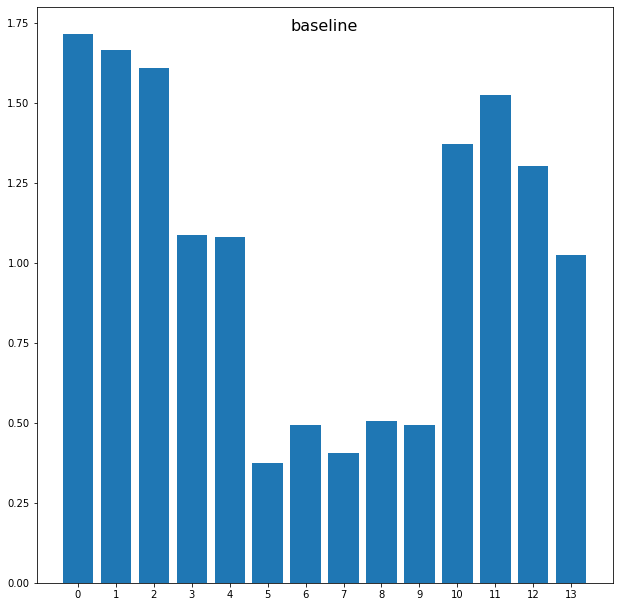

[1.7147461018558796, 1.665080601675228, 1.6093189849469705, 1.0876649842683437, 1.0819383536970213, 0.37572370141098166, 0.49478658475935844, 0.40651788309783454, 0.5056340970053906, 0.4934324213021037, 1.37300299139537, 1.524435679185529, 1.3025674867863177, 1.0236928278469763]
[True, True, True, True, False, False, False, False, False, False, True, True, True, False]


{'dense1_baseline': 100,
 'dense2_baseline': 10,
 'dense3_baseline': 100,
 'initialiser_cancelOut': 'glorout',
 'initialiser_pairwise': 'const',
 'k': 3,
 'l1_baseline': 0.001,
 'l1_cancelOut': 0.05,
 'l1_neuralfs': 0.0,
 'l1_pairwise': 0.05,
 'l1_regul': 0.01,
 'l2_baseline': 0.001,
 'l2_cancelOut': 0.05,
 'l2_neuralfs': 0.05,
 'l2_pairwise': 0.05,
 'l3_cancelOut': 0.3,
 'l3_pairwise': 0.0,
 'threshold_neuralfs': 0.05}
___________________________________
{'shape': (3350, 14),
 'shape_reduced_baseline': (3350, 7),
 'shape_reduced_cancelOut': (3350, 7),
 'shape_reduced_filter': (3350, 7),
 'shape_reduced_neuralFS': (335

In [32]:
modelList = ['filter','neuralFS','pairwise','cancelOut','regularized','baseline']
print(modelList)
result = testModels(X_train, y_train, modelList, params, epc=100, percent=False, nFeat=int((X_train.shape[1])/2), showFeat=True, cols=False)
pprint.pprint(params)
print("___________________________________")
pprint.pprint(result)
writeOut("resultFS.txt",params,result,dfstr)


75% of ranking

In [33]:
modelList = ['filter','neuralFS','pairwise','cancelOut','regularized','baseline']
print(modelList)
result = testModels(X_train, y_train, modelList, params, epc=100, percent=True, nFeat=75, showFeat=False, cols=False)
pprint.pprint(params)
print("___________________________________")
pprint.pprint(result)
writeOut("resultFS.txt",params,result,dfstr)


['filter', 'neuralFS', 'pairwise', 'cancelOut', 'regularized', 'baseline']
52/52 [==============================] - 0s 1ms/step - loss: 0.2512 - accuracy: 0.9248
$$__filter
[1.43181010e+00 1.42668167e+00 5.34613978e-01 1.97827584e+00
 8.78518824e-01 1.13520352e-01 3.85444810e-02 6.45414075e-02
 1.10087830e-01 4.33034813e-04 1.49985013e+00 1.43532992e+00
 6.89391902e-01 1.96564941e+00]
[True, True, False, True, False, False, False, False, False, False, True, True, False, True]


$$__neuralFS
52/52 [==============================] - 0s 1ms/step - loss: 0.2851 - accuracy: 0.9158
[0.24437028, 0.5581546, 0.0, 0.20752212, 0.13335875, 0.0, 0.19503424, 0.0, 0.0, 0.0, 0.5768623, 0.31753504, 0.026138237, 0.17154251]
[True, True, False, True, False, False, False, False, False, False, True, True, False, False]


$$__pairwise
52/52 [==============================] - 0s 2ms/step - loss: 0.4038 - accuracy: 0.8655
[0.0001629128, 0.15216036, 2.0426298e-06, 1.4534666e-06, 0.07778967, 7.293877e-05, 0.000

50% of ranking

In [34]:
modelList = ['filter','neuralFS','pairwise','cancelOut','regularized','baseline']
print(modelList)
result = testModels(X_train, y_train, modelList, params, epc=100, percent=True, nFeat=50, showFeat=False, cols=False)
pprint.pprint(params)
print("___________________________________")
pprint.pprint(result)
writeOut("resultFS.txt",params,result,dfstr)


['filter', 'neuralFS', 'pairwise', 'cancelOut', 'regularized', 'baseline']
52/52 [==============================] - 0s 1ms/step - loss: 0.2360 - accuracy: 0.9285
$$__filter
[ 1.43181010e+00  1.42668167e+00  5.34613978e-01  1.97827584e+00
  8.78518824e-01  1.13520352e-01  3.85444810e-02  6.45414075e-02
  1.10087830e-01 -3.19871390e-04  1.49985013e+00  1.43532992e+00
  6.89391902e-01  1.96564941e+00]
[False, False, False, True, False, False, False, False, False, False, True, True, False, True]


$$__neuralFS
52/52 [==============================] - 0s 2ms/step - loss: 0.2786 - accuracy: 0.9158
[0.505199, 0.5668115, 0.036601864, 0.34163338, 0.31329563, 0.0, 0.0, 0.0, 0.0, 0.0, 0.42226574, 0.3065828, 0.15700263, 0.0]
[True, True, False, False, False, False, False, False, False, False, True, False, False, False]


$$__pairwise
52/52 [==============================] - 0s 1ms/step - loss: 0.4044 - accuracy: 0.8667
[0.15780443, 0.12942564, 6.503457e-05, 0.12852491, 0.08082625, 1.5364038e-05, 8

['filter', 'neuralFS', 'pairwise', 'cancelOut', 'regularized', 'baseline']
52/52 [==============================] - 0s 1ms/step - loss: 0.2470 - accuracy: 0.9255
$$__filter
[1.43181010e+00 1.42668167e+00 5.34613978e-01 1.97827584e+00
 8.78518824e-01 1.13520352e-01 3.85444810e-02 6.45414075e-02
 1.10087830e-01 1.04844930e-04 1.49985013e+00 1.43532992e+00
 6.89391902e-01 1.96564941e+00]


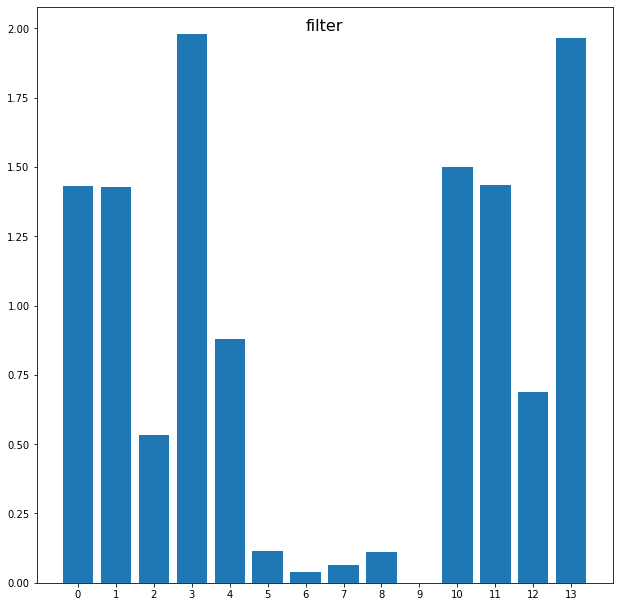

[1.43181010e+00 1.42668167e+00 5.34613978e-01 1.97827584e+00
 8.78518824e-01 1.13520352e-01 3.85444810e-02 6.45414075e-02
 1.10087830e-01 1.04844930e-04 1.49985013e+00 1.43532992e+00
 6.89391902e-01 1.96564941e+00]
[True, True, True, True, True, True, True, True, True, True, True, True, True, True]


$$__neuralFS
52/52 [==============================] - 0s 1ms/step - loss: 0.2480 - accuracy: 0.9315
[0.6924974, 0.58946204, 0.6000809, 0.5366285, 0.47442657, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3521604, 0.424587, 0.0]


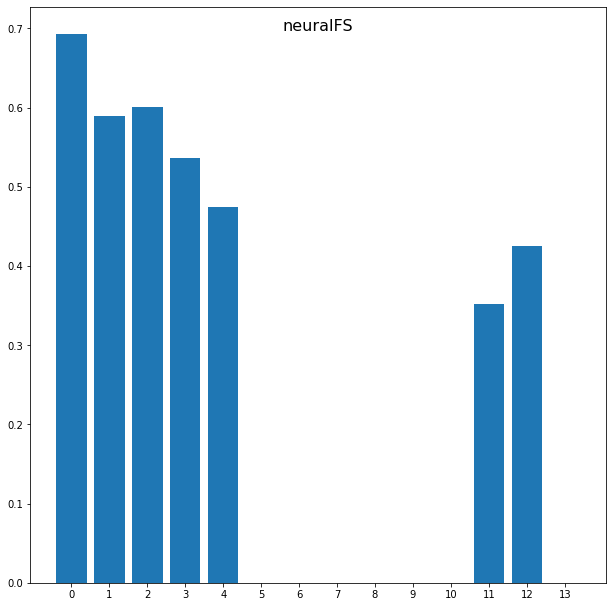

[0.6924974, 0.58946204, 0.6000809, 0.5366285, 0.47442657, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3521604, 0.424587, 0.0]
[True, True, True, True, True, False, False, False, False, False, False, True, True, False]


$$__pairwise
52/52 [==============================] - 0s 1ms/step - loss: 0.4048 - accuracy: 0.8661
[0.16087027, 0.1436241, 0.00043311992, 0.12303766, 0.08031352, 5.4246273e-05, 2.4982872e-05, 0.00030994447, 9.109303e-05, 0.0002608364, 7.5482394e-06, 0.01805963, 3.8539685e-05, 0.00027182008]


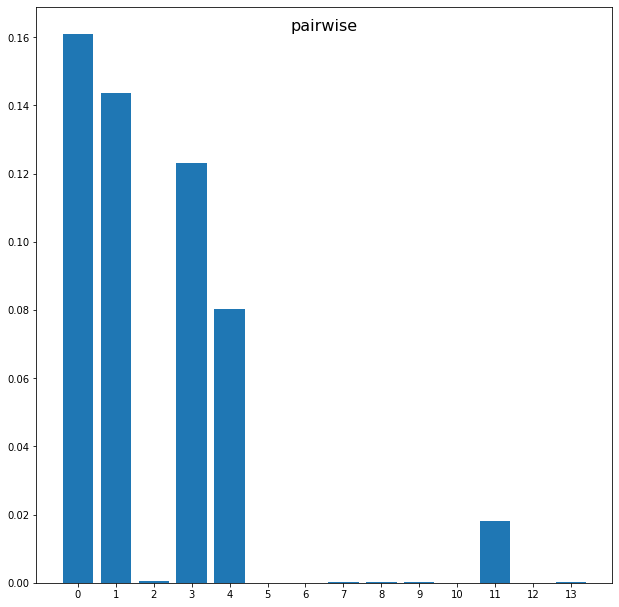

[0.16087027, 0.1436241, 0.00043311992, 0.12303766, 0.08031352, 5.4246273e-05, 2.4982872e-05, 0.00030994447, 9.109303e-05, 0.0002608364, 7.5482394e-06, 0.01805963, 3.8539685e-05, 0.00027182008]
[True, True, True, True, True, True, True, True, True, True, False, True, True, True]


$$__cancelOut
52/52 [==============================] - 0s 1ms/step - loss: 0.2527 - accuracy: 0.9303
[0.0011291457, 0.0008314883, 0.00023335051, 0.0011067915, 0.0002461096, 0.00014606563, 0.00013626287, 0.00010890377, 1.0331998e-05, 7.604959e-05, 0.0005404097, 0.00049954094, 6.5001615e-05, 0.0015118812]


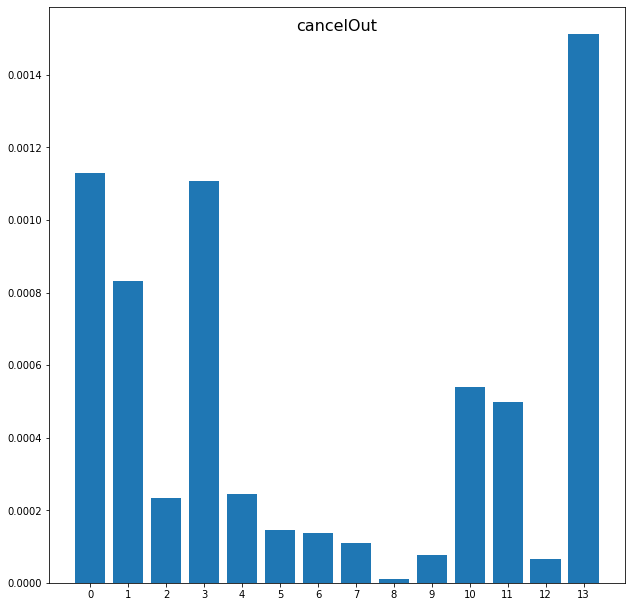

[0.0011291457, 0.0008314883, 0.00023335051, 0.0011067915, 0.0002461096, 0.00014606563, 0.00013626287, 0.00010890377, 1.0331998e-05, 7.604959e-05, 0.0005404097, 0.00049954094, 6.5001615e-05, 0.0015118812]
[True, True, True, True, True, True, True, True, True, True, True, True, True, True]


$$__regularized
52/52 [==============================] - 0s 1ms/step - loss: 0.2818 - accuracy: 0.9248
[0.3060016992083614, 0.29686091112258983, 0.24617418392002438, 0.18524548069684388, 0.17097867975241593, 0.0135749794532631, 0.007149849236426184, 0.015562490719977628, 0.01624060537569805, 0.015510231090592786, 0.20930665793120365, 0.21267985048900662, 0.23950241081407872, 0.10338950637431274]


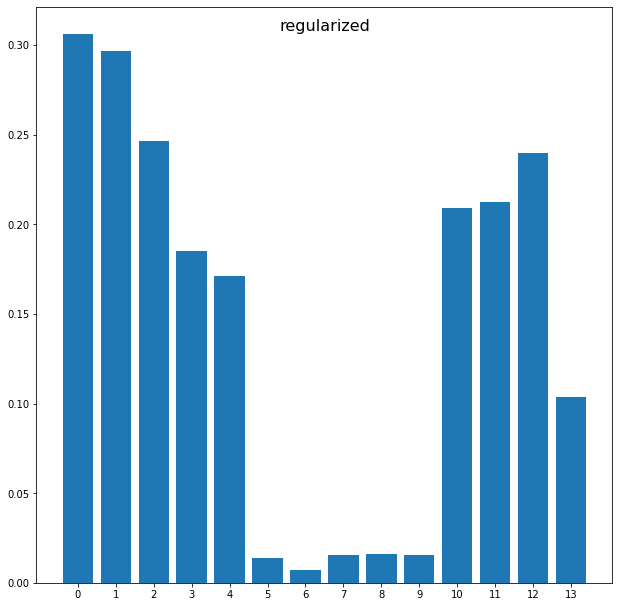

[0.3060016992083614, 0.29686091112258983, 0.24617418392002438, 0.18524548069684388, 0.17097867975241593, 0.0135749794532631, 0.007149849236426184, 0.015562490719977628, 0.01624060537569805, 0.015510231090592786, 0.20930665793120365, 0.21267985048900662, 0.23950241081407872, 0.10338950637431274]
[True, True, True, True, True, True, True, True, True, True, True, True, True, True]


$$__baseline
52/52 [==============================] - 1s 1ms/step - loss: 0.2456 - accuracy: 0.9285
[1.6355443955203195, 1.6632448435172682, 1.511138424689439, 1.3201833761838764, 1.0829433369459012, 0.4549603444817472, 0.5837642446262912, 0.30116807220828185, 0.36640023144785805, 0.286065207558617, 1.4901843317258037, 1.4135391985995567, 1.2081829397503259, 0.7281401493352225]


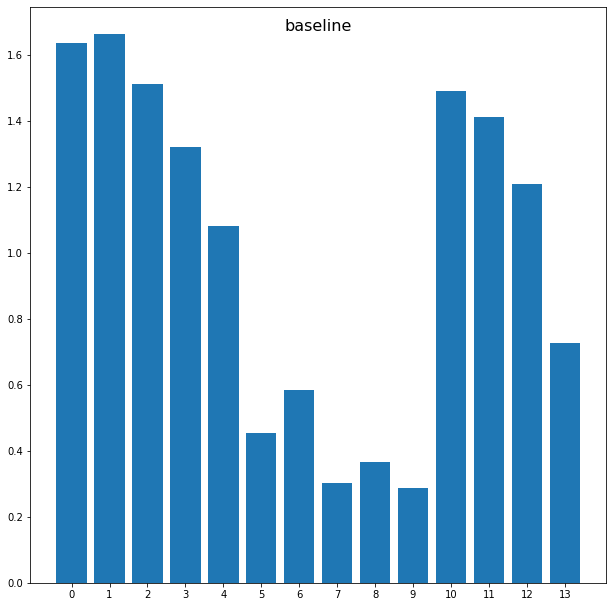

[1.6355443955203195, 1.6632448435172682, 1.511138424689439, 1.3201833761838764, 1.0829433369459012, 0.4549603444817472, 0.5837642446262912, 0.30116807220828185, 0.36640023144785805, 0.286065207558617, 1.4901843317258037, 1.4135391985995567, 1.2081829397503259, 0.7281401493352225]
[True, True, True, True, True, True, True, True, True, True, True, True, True, True]


{'dense1_baseline': 100,
 'dense2_baseline': 10,
 'dense3_baseline': 100,
 'initialiser_cancelOut': 'glorout',
 'initialiser_pairwise': 'const',
 'k': 3,
 'l1_baseline': 0.001,
 'l1_cancelOut': 0.05,
 'l1_neuralfs': 0.0,
 'l1_pairwise': 0.05,
 'l1_regul': 0.01,
 'l2_baseline': 0.001,
 'l2_cancelOut': 0.05,
 'l2_neuralfs': 0.05,
 'l2_pairwise': 0.05,
 'l3_cancelOut': 0.3,
 'l3_pairwise': 0.0,
 'threshold_neuralfs': 0.05}
___________________________________
{'shape': (3350, 14),
 'shape_reduced_baseline': (3350, 14),
 'shape_reduced_cancelOut': (3350, 14),
 'shape_reduced_filter': (3350, 14),
 'shape_reduced_neuralFS': (3350, 

In [35]:
modelList = ['filter','neuralFS','pairwise','cancelOut','regularized','baseline']
print(modelList)
result = testModels(X_train, y_train, modelList, params, epc=100, percent=True, nFeat=100, showFeat=True, cols=False)
pprint.pprint(params)
print("___________________________________")
pprint.pprint(result)
writeOut("resultFS.txt",params,result,dfstr)

### Stability

In [36]:
def crossStab(key,k,X_train,y_train, mapModel, param, percent, nFeat, epc, bs, verb):
    n_splits = k
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    sups = []
    for train_index, val_index in kf.split(X_train):
        model = mapModel[key](X_train,y_train,params)
        model.compile(optimizer='adam',
          loss=losses.CategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])
        model.fit(X_train,y_train,epochs=epc, verbose=0)
        test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=1)
        if key in ["baseline", "regularized", "dropout"]:
            w = activation_potential_analysis(X_train, model.get_weights())
            w = [abs(number) for number in w]
        else:
            w = model.get_support()
            w = [abs(number) for number in w]
        if percent == True:
            support = computeSupportPercent(w,nFeat)
        else:
            support = computeSupport(w,nFeat)
        sups.append(support)
    dim = len(sups[0])
    if percent == True:
        jacc_index = jaccardIndex(sups,k,dim)
        print("Mean jacc index ",key,": ",jacc_index)

    else:
        kun_index = kunchevaIndex(sups,k,dim, nFeat)
        print("Kuncheva index ", key,": ",kun_index)

In [37]:
def jaccardIndex(sups, k, dim):
    jacc = 0
    count = 0
    print("h",k)
    print(sups)
    for i in range(k-1):
        for j in range(i+1,k):
            if i != j:
                count += 1
                card = 0
                a = 0
                for l in range(dim):
                    if sups[i][l] == True or sups[j][l] == True:
                        a += 1
                    if sups[i][l] == True and sups[j][l] == True:
                        card += 1
                jacc += (card/(a))
    jacc_index = jacc/count
    return jacc_index

In [38]:
def kunchevaIndex(sups,k, dim, nFeat):
    interKun = 0
    for i in range(k-1):
        for j in range(i+1,k):
            card = 0
            for l in range(dim):
                if sups[i][l] == True and sups[j][l] == True:
                    card += 1
            interKun += (card - ((nFeat**2)/dim)) / (nFeat - ((nFeat**2)/dim)) 
    kun_index =  2*interKun/(k*(k-1))
    return kun_index

75% of ranking

In [39]:
train = True
modelList = ['baseline','neuralFS','pairwise','cancelOut','regularized']
if train:
    for key in modelList:
        if key != "filter":
            crossStab(key,4,X_train,y_train,mapModel, params, percent=True, nFeat=75, epc=100, bs=32, verb=0)

52/52 [==============================] - 0s 1ms/step - loss: 0.2386 - accuracy: 0.9242
[1.3622160411537034, 1.4200785353633145, 1.429658057596302, 1.171356822278194, 1.0718497357887693, 0.38710481833492033, 0.5062594664827413, 0.4334770479911818, 0.5880318254981463, 0.2571542433603841, 1.1360938077936231, 1.1368853981288851, 1.1531726451391313, 0.6481895528261686]
52/52 [==============================] - 0s 2ms/step - loss: 0.2484 - accuracy: 0.9212
[1.5157354672106622, 1.5856031606325505, 1.2697055702347049, 1.04651231741534, 0.9775997319638092, 0.36033601886864686, 0.45713459101808035, 0.44470803954624427, 0.42204612825455234, 0.3813302410894104, 1.3194855184757364, 1.5157708359522046, 0.9958583650256746, 0.7788371535272207]
52/52 [==============================] - 0s 2ms/step - loss: 0.2453 - accuracy: 0.9224
[1.7539600558550994, 1.7140140696174373, 1.3799760425030618, 1.2375016654326805, 1.1053097693339737, 0.49998714635040015, 0.404201925070717, 0.3370678368089669, 0.3821326475579

50% of ranking

In [40]:
train = True
modelList = ['baseline','neuralFS','pairwise','cancelOut','regularized']
if train:
    for key in modelList:
        if key != "filter":
            crossStab(key,4,X_train,y_train,mapModel, params, percent=True, nFeat=50, epc=100, bs=32, verb=0)

52/52 [==============================] - 0s 1ms/step - loss: 0.2336 - accuracy: 0.9267
[1.1991760416061008, 1.3362261771108856, 1.0823278181596838, 0.7279141327766642, 0.780701384462094, 0.29288873788113134, 0.37899976341800357, 0.24337891008931034, 0.20142611812941438, 0.2479267306711838, 1.088447962812198, 1.0992055366564042, 1.0988802863330747, 0.7380707609450271]
52/52 [==============================] - 0s 1ms/step - loss: 0.2786 - accuracy: 0.9115
[1.2121716987884041, 1.4546068420024585, 1.3845611318627429, 1.0056393395208776, 0.8205385413670593, 0.3387323370049056, 0.4614936092566077, 0.3207033819579477, 0.31751412604140206, 0.3810546955484164, 1.1585197267603395, 1.3267938094940837, 1.0282590455408502, 0.7952174614123807]
52/52 [==============================] - 1s 1ms/step - loss: 0.2513 - accuracy: 0.9230
[1.816111477703223, 1.6872121575557195, 1.3454678674196652, 0.984232537359133, 1.1659587724048925, 0.530735370560936, 0.4861575545122259, 0.37253511280264434, 0.4676263312643

middle of dataset

In [ ]:
train = True
modelList = ['baseline','neuralFS','pairwise','cancelOut','regularized']
if train:
    for key in modelList:
        if key != "filter":
            crossStab(key,4,X_train,y_train,mapModel, params, percent=False, nFeat=int((X_train.shape[1])/2), epc=100, bs=32, verb=0)

52/52 [==============================] - 0s 1ms/step - loss: 0.2385 - accuracy: 0.9273
[1.471585353512388, 1.7482593850853363, 1.5979249728379143, 0.9800818624329136, 0.9681732125343449, 0.43005796620952386, 0.4545614116824362, 0.28190827410721814, 0.3332600786190769, 0.27102853650034625, 1.3408479458848692, 1.0932161933027098, 1.1919073240602993, 0.9282012237292162]
52/52 [==============================] - 0s 1ms/step - loss: 0.2479 - accuracy: 0.9242
[1.5702626561858237, 1.6546124496071406, 1.4137409481478105, 1.1118408210371755, 0.9170208426785558, 0.37987380074175564, 0.3550815360956802, 0.24825763217731253, 0.4319015211883673, 0.2552002453117346, 1.3898959069251782, 1.2472722136980443, 1.229715162355646, 0.9893070235851853]
52/52 [==============================] - 0s 2ms/step - loss: 0.2510 - accuracy: 0.9248
[1.868954037174681, 1.8880488664325867, 1.5249810723003916, 1.3270643239467037, 0.9924267410567087, 0.413021346150528, 0.3957000075171188, 0.3223336247658524, 0.4622061085986

In [ ]:
def testAll(modelList,params):
  print(modelList)
  print("100% OF FEATURES")
  result = testModels(X_train, y_train, modelList, params, epc=100, percent=True, nFeat=100, showFeat=False, cols=False)
  pprint.pprint(params)
  print("___________________________________")
  pprint.pprint(result)
  writeOut("resultFS.txt",params,result,dfstr)
  print("#######################################################")
  print("75% OF FEATURES")
  result = testModels(X_train, y_train, modelList, params, epc=100, percent=True, nFeat=75, showFeat=False, cols=False)
  pprint.pprint(params)
  print("___________________________________")
  pprint.pprint(result)
  writeOut("resultFS.txt",params,result,dfstr)
  print("#######################################################")
  print("50% OF FEATURES")
  result = testModels(X_train, y_train, modelList, params, epc=100, percent=True, nFeat=50, showFeat=False, cols=False)
  pprint.pprint(params)
  print("___________________________________")
  pprint.pprint(result)
  writeOut("resultFS.txt",params,result,dfstr)
  print("#######################################################")
  print("MIDDLE OF FEATURES")
  result = testModels(X_train, y_train, modelList, params, epc=100, percent=True, nFeat=int((X_train.shape[1])/2), showFeat=False, cols=False)
  pprint.pprint(params)
  print("___________________________________")
  pprint.pprint(result)
  writeOut("resultFS.txt",params,result,dfstr)
  print("#######################################################")
  print("Stability 75%")
  crossStab(key,4,X_train,y_train,mapModel, params, percent=True, nFeat=75, epc=100, bs=32, verb=0)
  print("#######################################################")
  print("Stability 50%")
  crossStab(key,4,X_train,y_train,mapModel, params, percent=True, nFeat=50, epc=100, bs=32, verb=0)
  print("#######################################################")
  print("Stability Middle of feature")
  crossStab(key,4,X_train,y_train,mapModel, params, percent=False, nFeat=int((X_train.shape[1])/2), epc=100, bs=32, verb=0)
  print("#######################################################")

Influence of L1 param


In [ ]:
paramz = params.copy()
modelList = ["cancelOut","pairwise","regularized"]
for i in [0.01,0.1,0.3,0.5,0.8]:
  paramz["l1_cancelOut"] = i
  paramz["l1_pairwise"] = i
  paramz["l1_regul"] = i
  testAll(modelList,paramz)

['cancelOut', 'pairwise', 'regularized']
100% OF FEATURES
52/52 [==============================] - 0s 1ms/step - loss: 0.2552 - accuracy: 0.9236
$$__cancelOut
52/52 [==============================] - 0s 1ms/step - loss: 0.2469 - accuracy: 0.9309
[0.00031921937, 0.00029506139, 0.00045871284, 0.0008666182, 9.0060115e-05, 0.00012488895, 0.00025720714, 3.6004432e-05, 7.4686024e-05, 1.04173005e-05, 0.00021286859, 0.00011552746, 0.00063157146, 0.001029449]
[True, True, True, True, True, True, True, True, True, True, True, True, True, True]


$$__pairwise
52/52 [==============================] - 0s 1ms/step - loss: 0.3777 - accuracy: 0.8673
[0.20364556, 0.2552519, 0.00028864996, 0.00014040622, 0.14392486, 0.00019631363, 5.516152e-05, 0.00020142994, 0.00018446067, 5.6133624e-05, 0.1656282, 8.4763615e-06, 0.00021135579, 0.21762961]
[True, True, True, True, True, True, True, True, True, True, True, False, True, True]


$$__regularized
52/52 [==============================] - 0s 1ms/step - loss: 

Influence of L2 param


In [ ]:
paramz = params.copy()
modelList = ["cancelOut","pairwise", "neuralFS"]
for i in [0.01,0.1,0.3,0.5,0.8]:
  paramz["l2_cancelOut"] = i
  paramz["l2_pairwise"] = i
  paramz["l2_neuralfs"] = i
  testAll(modelList,paramz)

Influence of L3 param


In [ ]:
paramz = params.copy()
modelList =["cancelOut","pairwise","regularized"]
for i in [0.01,0.1,0.3,0.5,0.8]:
  paramz["l3_cancelOut"] = i 
  paramz["l3_pairwise"] = i
  testAll(modelList,paramz)

Influence of threshold


In [ ]:
paramz = params.copy()
modelList = ["neuralFS"]
for i in [0.01,0.1,0.3,0.5,0.8]:
  paramz["threshold_neuralfs"] = i 
  testAll(modelList,paramz)